In [ ]:

!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 15.3 MB/s 
     |████████████████████████████████| 212 kB 53.7 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [ ]:
tweets, labels = get_tweets(train)

In [ ]:
tweets[10], labels[10]

('i feel like i have to make the suffering i m seeing mean something',
 'sadness')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[10]]))

[[2, 3, 14, 2, 21, 5, 80, 6, 733, 2, 93, 544, 304, 84]]


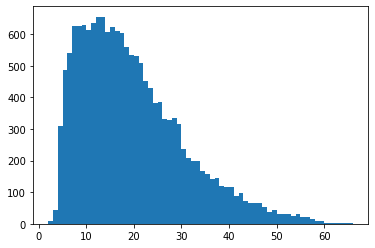

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [ ]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_sequences[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
classes = set(labels)
print(classes)

{'sadness', 'anger', 'love', 'joy', 'fear', 'surprise'}


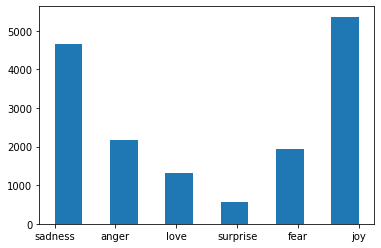

In [ ]:
plt.hist(labels, bins=11)
plt.show()

In [ ]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [ ]:
classes_to_index

{'sadness': 0, 'anger': 1, 'love': 2, 'joy': 3, 'fear': 4, 'surprise': 5}

In [ ]:
index_to_classes

{0: 'sadness', 1: 'anger', 2: 'love', 3: 'joy', 4: 'fear', 5: 'surprise'}

In [ ]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[10])

0


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [ ]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[20], val_labels[20]

('i just know to begin with i am going to feel shy about it', 4)

In [ ]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/15
500/500 [==============================] - 16s 15ms/step - loss: 1.3599 - accuracy: 0.4665 - val_loss: 0.8694 - val_accuracy: 0.6720
Epoch 2/15
500/500 [==============================] - 7s 14ms/step - loss: 0.6193 - accuracy: 0.7802 - val_loss: 0.5712 - val_accuracy: 0.8085
Epoch 3/15
500/500 [==============================] - 6s 13ms/step - loss: 0.3093 - accuracy: 0.8998 - val_loss: 0.4250 - val_accuracy: 0.8760
Epoch 4/15
500/500 [==============================] - 6s 13ms/step - loss: 0.1863 - accuracy: 0.9397 - val_loss: 0.4207 - val_accuracy: 0.8705
Epoch 5/15
500/500 [==============================] - 6s 12ms/step - loss: 0.1246 - accuracy: 0.9621 - val_loss: 0.4111 - val_accuracy: 0.8795
Epoch 6/15
500/500 [==============================] - 6s 13ms/step - loss: 0.0974 - accuracy: 0.9694 - val_loss: 0.4030 - val_accuracy: 0.8855
Epoch 7/15
500/500 [==============================] - 7s 14ms/step - loss: 0.0808 - accuracy: 0.9759 - val_loss: 0.4569 - val_accuracy: 0.876

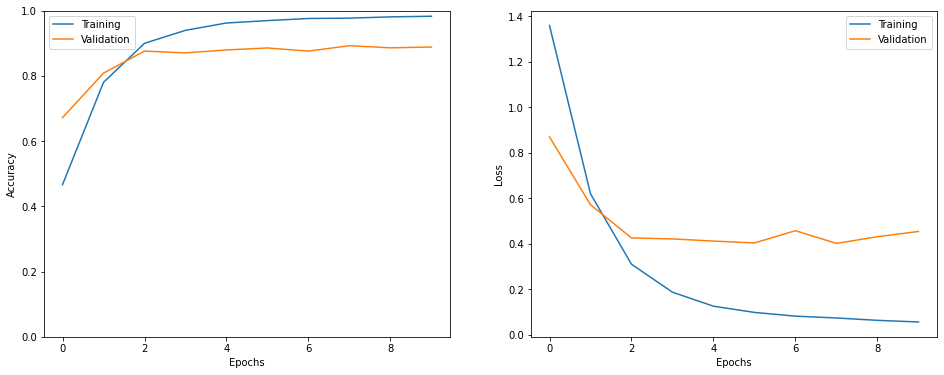

In [ ]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [ ]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
eval = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4636 - accuracy: 0.8805


In [ ]:
for a in range(0,10):
  i = random.randint(1, len(test_labels) - 1)

  print('Tweet:', test_tweets[i])
  print('Actual Emotion:', index_to_classes[test_labels[i]])

  p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]

  print('Predicted Emotion:', index_to_classes, '\n')

Tweet: i felt so bad for the bad grade and feeling like having to hide it that i didnt know what to say except to declare in all my frustration that i hated school
Actual Emotion: sadness
1/1 [==============================] - 1s 1s/step
Predicted Emotion: {0: 'sadness', 1: 'anger', 2: 'love', 3: 'joy', 4: 'fear', 5: 'surprise'} 

Tweet: im feeling slightly irritable today
Actual Emotion: anger
1/1 [==============================] - 0s 19ms/step
Predicted Emotion: {0: 'sadness', 1: 'anger', 2: 'love', 3: 'joy', 4: 'fear', 5: 'surprise'} 

Tweet: i feel your prescence a gentle touch
Actual Emotion: love
1/1 [==============================] - 0s 20ms/step
Predicted Emotion: {0: 'sadness', 1: 'anger', 2: 'love', 3: 'joy', 4: 'fear', 5: 'surprise'} 

Tweet: i feel sorta vain
Actual Emotion: sadness
1/1 [==============================] - 0s 17ms/step
Predicted Emotion: {0: 'sadness', 1: 'anger', 2: 'love', 3: 'joy', 4: 'fear', 5: 'surprise'} 

Tweet: i was gifted one of the books but am fee

In [ ]:
preds = model.predict(test_sequences)
preds.shape, test_labels.shape

63/63 [==============================] - 0s 6ms/step


((2000, 6), (2000,))